# Speech sound reconstruction via `WCA1`

In [1]:
import Pkg
Pkg.activate("..")
import WCA1

 Activating environment at `/mnt/data/L2S/myWCA1/Project.toml`
┌ Info: Precompiling WCA1 [f15acf5a-a3df-11e9-3331-7bf93435fc23]
└ @ Base loading.jl:1278
┌ Warning: Package WCA1 does not have Distributions in its dependencies:
│ - If you have WCA1 checked out for development and have
│   added Distributions as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with WCA1
└ Loading Distributions into WCA1 from project dependency, future warnings for WCA1 are suppressed.


In [2]:
# import speech recording
x, fs = WCA1.wavread("../samples/speech_lib/calo.wav")
x = vec(x)

# play recording
include("../tests/utils.jl")
play_audio(x, fs)

PyObject <IPython.lib.display.Audio object>

## Test Pipeline

### Calculate STFT of signal

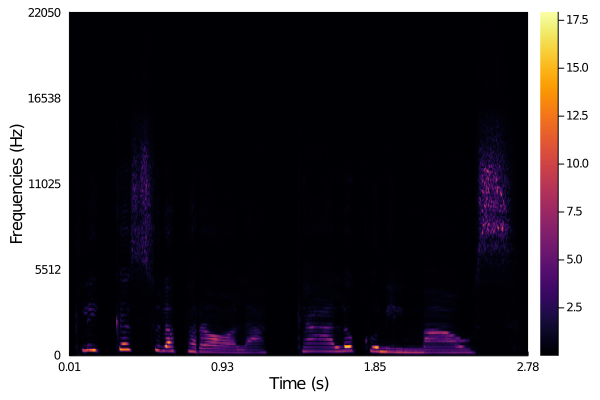

In [3]:
fft_width = 500
overlap = 9//10
noverlap = round(Int, fft_width * overlap)
X = WCA1.stft(x, fft_width, noverlap; fs=fs, window=WCA1.hanning)
WCA1.show_stft(X)

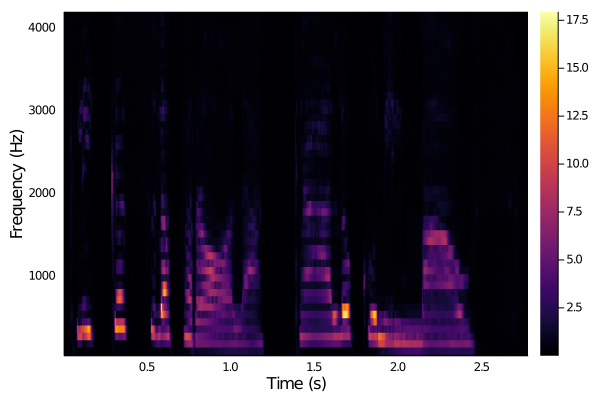

In [4]:
using Plots

# show STFT piano frequency range
WCA1.plot_heatmap(abs.(X.stft); time=X.time, freq=X.freq)
ylims!((27,4186))

### Evolution in the contact space

We first lift the signal.

In [5]:
@time L = WCA1.lift(X; N=100);

size(L)

  7.559898 seconds (6.49 M allocations: 1.437 GiB, 3.45% gc time)


(251, 2445, 100)

We then evolve it, according to the following Wilson-Cowan equation with delay:
$$
    \partial_\tau a(\tau, \omega, \nu) = -\alpha a(\tau,\omega,\nu)+\beta L(\tau,\omega,\nu) +\gamma\int_{\mathbb R^2} w(\omega,\nu\|\omega',\nu') \sigma(a(\tau-\delta, \omega', \nu')) \,d\omega'\,d\nu'
$$

In [10]:
# dry run for compilation purposes
@time WCA1.wc_delay(L, 0., 0., 0.);

WC evolution...100%|███████████████████████████████████▉|  ETA: 0:00:00

 22.938454 seconds (1.05 M allocations: 10.567 GiB, 19.89% gc time)


WC evolution...100%|███████████████████████████████████▉|  ETA: 0:00:00

 65.649130 seconds (1.69 M allocations: 10.647 GiB, 18.84% gc time)


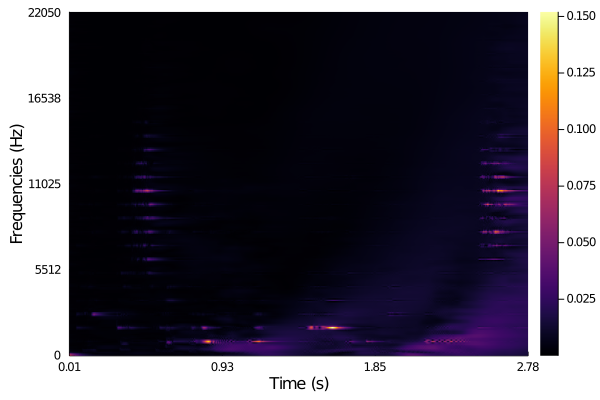

In [11]:
α = 16
β = 1
γ = 18

@time W = WCA1.wc_delay(L, α, β, γ, b = 4)

WCA1.show_stft(W)

In [12]:
WCA1.show_istft(W)

In [13]:
w = WCA1.istft(WCA1.project(W))
play_audio(w, fs)

PyObject <IPython.lib.display.Audio object>

## Reconstruct cut sound

## Reconstruct sound with added noise